## 0. Import Libraries

For ease of use and ram, run each indices in different sessions

In [3]:
import climextremes
import sys 
import time

import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

## 1. Data Options

In [4]:
# change these
season = 'JJA' # DJF, JJA,
time_resample = 6 # options: 1, 3, 6 (resampling)

# bias algorithm
bias_algo = 'QDM'

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'data/{name_variable_cosmo}/'

# years
years = np.arange(1985, 2006, dtype=int)

## 2. Intensity Indices

### 2.1 Open Data

In [5]:
intensity_indice_name = fr'rx{time_resample}hr'
intensity_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [6]:
# get the attributes in a dict
intensity_indice_attrs = intensity_idx_cosmo.attrs

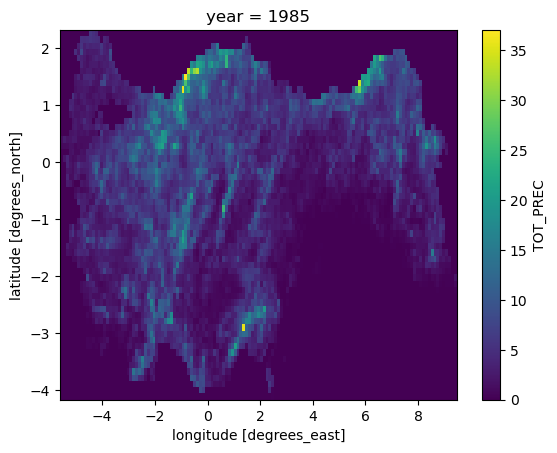

In [7]:
intensity_idx_cosmo[0].plot()

In [8]:
# test data
dt_test = intensity_idx_cosmo.stack(horizontal = ('rlat', 'rlon'))

.sel(rlat=slice(0.5, 1),
                        rlon=slice(-2, -1))

In [9]:
dt_test

<xarray.DataArray 'TOT_PREC' (year: 21, horizontal: 8083)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lon         (horizontal) float32 26.18 26.31 26.45 ... 45.33 45.47 45.62
    lat         (horizontal) float32 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
  * year        (year) int64 1985 1986 1987 1988 1989 ... 2002 2003 2004 2005
  * horizontal  (horizontal) MultiIndex
  - rlat        (horizontal) float64 -4.11 -4.11 -4.11 -4.11 ... 2.27 2.27 2.27
  - rlon        (horizontal) float64 -5.55 -5.44 -5.33 -5.22 ... 9.19 9.3 9.41
Attributes:
    computation:  grouped by year and took maximum over time dimension
    indice_name:  rx6hr

In [10]:
np.shape(dt_test)

(21, 8083)

### 2.2 GEV

In [11]:
def delete_last_lines(num_grid, grid): 
    
    # display setting
    if not num_grid - grid == 1:
        clear_output(wait=True)
        
def fit_stationary_gev_model(data, grid, return_period):
    """
    Returns:
    location, scale, shape, return_value, neg_log_likelihood
    
    """

    intensity_model = climextremes.fit_gev(y=data.values[:, grid],
                                           returnPeriod = return_period,
                                           getParams = True,
                                           getFit = True,
                                             )
    
    location = intensity_model['mle'][0]
    scale = intensity_model['mle'][1]   
    shape = intensity_model['mle'][2]   
    return_value = intensity_model['returnValue'][0]
    neg_log_likelihood = intensity_model['nllh'][0]
    
    return location, scale, shape, return_value, neg_log_likelihood

#### 2.2.1 Stationary

In [ ]:
%%time
# build a stationary GEV model

# introduce parameters
return_period=100
num_param = 5
num_year = np.shape(dt_test)[0]
num_grid = np.shape(dt_test)[1]

# in order: location, scale, shape, return_value, neg_log_likelihood
parameter_array = np.empty((num_grid, num_param)) # 5 for parameter space
error_array = []

# loop over grids
for grid in range(num_grid):
    
    try:
        gev = fit_stationary_gev_model(dt_test, 
                          grid, 
                          return_period,
                         )

        # fill in required parameters
        for param_space in range(num_param):
            parameter_array[grid, param_space] = gev[param_space]
        
        # display results
        print(fr"done with grid number: {grid}")
        
    except:
        
        # report grid
        error_array.append(grid)
        
        # fill in required parameters with nan
        for param_space in range(num_param):
            parameter_array[grid, param_space] = np.nan
            
        # display results
        print(fr"problem with grid number: {grid}")
        
    # display setting
    delete_last_lines(num_grid, grid)

In [13]:
# number of nans found
parameter_array[np.isnan(parameter_array)].sum()

nan

In [15]:
len(error_array)

3181

In [16]:
parameter_array

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [19]:
parameter_array[~np.isnan(parameter_array)]

array([ 0.73845071,  0.8596087 ,  0.4214112 , ..., -0.13887347,
       18.51246397, 58.40169597])

## Extra

In [61]:
np.shape(np.array([[1,2,3],
         [4,5,6]]))

(2, 3)

In [71]:
np.array([[1,2,3],
         [4,5,6]]).transpose().flatten()

array([1, 4, 2, 5, 3, 6])